# More accurate prediction of metastasis 

For this notebook, we will use the following [tutorial](https://geertlitjens.nl/post/getting-started-with-camelyon/).


In [5]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

# Import warning to remove all the extra warnings
import warnings
warnings.filterwarnings('ignore')

## Load the Data

Install `tensorflow_datasets` in the environment. 
Load the data from he tensorflow_datasets. This is a more direct route in getting the files. Plus it doesn't have a HDF5Matrix value (similar to numpys)

In [4]:
import tensorflow_datasets as tfds
pcam, pcam_info = tfds.load("patch_camelyon", with_info=True)
print(pcam_info)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTT

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


W0827 20:34:26.767880 35904 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_datasets\core\file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset patch_camelyon downloaded and prepared to C:\Users\romin\tensorflow_datasets\patch_camelyon\0.1.0. Subsequent calls will reuse this data.
Instructions for updating:
Colocations handled automatically by placer.


W0827 20:49:22.138047 35904 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
W0827 20:49:22.213844 35904 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=0.1.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.
',
    urls=['https://patchcamelyon.grand-challenge.org/'],
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_2

In [13]:
type(pcam)

dict

In [27]:
len(pcam)

3

In [14]:
type(pcam_info)

tensorflow_datasets.core.dataset_info.DatasetInfo

## Set up the Model's Layers

In [6]:
# Set up the input shape of the images which is 96x96 pixels with 3 channels
input_img = Input(shape=(96,96,3))

# Define the Convolutional Neural network layers
# Define three blocks: each containing 2 convolutional layers and one max-pool layer
# size 16
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# size 32
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# size 64
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Flatten the layer from 4D to 2D -- need this to add the dense layers at the end.
x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# Add Dropout for regularization. 
x = Dropout(rate=0.2)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)

# Add a softmax layer in the  last dense layer -- with predict one of the two outcomes: tumors or non-tumors.
predictions = Dense(2, activation='softmax')(x)

# Define inputs the images
# and output the predictions 
model = Model(inputs=input_img, outputs=predictions)

# Will use the Stochastic Gradient Descent
# with Nesterov Momentum.
sgd_opt = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)

#for loss we'll use categorical_crossentropy
model.compile(optimizer=sgd_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])  #save the accuracy as a metrics

# See the Model Summary
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0827 20:49:34.201808 35904 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 94, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 32)        0         
__________

In [20]:
print(list(pcam.keys())[0])

test


In [21]:
print(list(pcam.keys())[1])

train


In [19]:
print(list(pcam.keys())[2])


validation


Next, we need to define function that will convert the images that are stores in the dictionary into float32. Up until now, they are stored as int8 patches.

In [7]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label


Define a `tf.data` pipeline that will convert the images. Using a `shuffle` we will pick random $1024$ samples.
For training we'll use batches of $64$ and for validation batches of $128$. Add a `prefetch` to be able to prefetch two of those batches.

The `map` function is much better than replace as we are dealing with a large data size. More details [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) 

In [ ]:
# the map function is much better than replace as we are dealing with a large data size.

In [8]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

## Fit the model

Fit the model on the train pipeline, validated it on the validation pipeline, set the number of epochs to 5, with a step of 4096. Those numbers cover all the training and validation datasets.

In [ ]:
hist = model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 verbose=2, epochs=5, steps_per_epoch=4096, validation_steps=256)

## Test Accuracy

Create the test pipeline. Then check the test accuracy.

In [10]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)
print("Test set accuracy is {0:.4f}".format(model.evaluate(test_pipeline, steps=128, verbose=0)[1]))


Test set accuracy is 0.8150


Save the model

In [11]:
model.save("./patchcamelyon.hf5")

## Visualize Loss and Accuracy

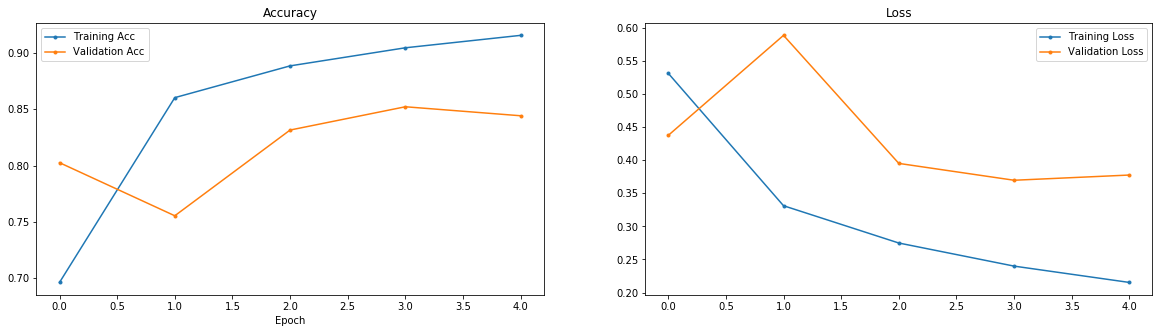

In [12]:
# Get the training history 
history = model.history 

# Accuracy and loss for test set
acc = history.history['acc']
loss = history.history['loss']

# Accuracy and loss for validation set
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

# Accuracy
plt.figure(figsize= (20,5))
plt.subplot(1,2,1)
plt.plot(acc, label='Training Acc', marker='.')
plt.plot(val_acc, label='Validation Acc', marker='.')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss', marker='.')
plt.plot(val_loss, label='Validation Loss', marker='.')
plt.title('Loss')
plt.legend()
plt.show()

This model has turned out great. The accuracy improves over the time whereas the loss decreases.